In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_csv('mobiles.csv', sep=';')
df.head(2)

,title,char,price
0,"Смартфон Xiaomi Redmi 9C 3/64GB, черный M2006C...",Диагональ экрана: 6.53Оперативная память: 3 ГБ...,9231
1,"Смартфон Xiaomi Redmi 9A 2/32GB, синий",Диагональ экрана: 6.53Оперативная память: 2 ГБ...,7584


Для начала отчистим данные и добавим признаки

In [5]:
# delete excess text from title
def replace_excess_text(df):
    df['title'] = df['title'].str.replace('Смартфон ', '').replace('%,%', '') \
                                 .map(lambda x: re.split('\d/', x)[0].strip()) \
                                 .map(lambda x: re.split(' ', x)[0])
    
    
def create_screen_size(x):
    if re.search('Диагональ экрана: \d+[.]\d{1,5}?', x):
        return re.search('Диагональ экрана: \d+[.]\d{1,5}', x)[0][18:]
    elif re.search('Диагональ экрана: \d\D', x):
        return re.search('Диагональ экрана: \d', x)[0][18:]
    return None


# Function for get int labels from unique string values
def marking_strings(df, column): 
    dict_unique_strings = {}
    label = 0
    for i in range(df.shape[0]):
        string = df[column][i]
        if string not in dict_unique_strings:
            dict_unique_strings[string] = label
            label += 1
    return dict_unique_strings
        
        
# Бренд – brand, Диагональ экрана – screen_size, Оперативная память – ram, Кол-во ядер – cpu_core
# Встроенная память – Memory storage capacity(msc), Разрешение основной камеры – mp, Процессор – cpu
replace_excess_text(df)
brand_int = marking_strings(df, 'title')
df['brand_int'] = df['title'].map(lambda x: brand_int[x])
df['screen_size'] = df['char'].map(lambda x: create_screen_size(x))
df['ram'] = df['char'].map(lambda x: re.search('Оперативная память: \d{1,5}', x)[0][20:]
                    if re.search('Оперативная память: \d{1,5}', x) else None)
df['msc'] = df['char'].map(lambda x: re.search('Встроенная память: \d{1,5}', x)[0][19:]
                    if re.search('Встроенная память: \d{1,5}', x) else None)
df['mp'] = df['char'].map(lambda x: re.search('Разрешение основной камеры: \d{1,5}', x)[0][28:]
                if re.search('Разрешение основной камеры: \d{1,5}', x) else None)
df['cpu'] = df['char'].map(lambda x: re.search('Процессор: [^>]*ГГц', x)[0]
                if re.search('Процессор: [^>]*ГГц', x) else None).astype(str)
cpu_int = marking_strings(df, 'cpu')
df['cpu_int'] = df['cpu'].map(lambda x: cpu_int[x])
df['cpu_ghz'] = df['cpu'].map(lambda x: re.search('\d+[.]\d{1,4}', x)[0]
                    if re.search('\d+[.]\d{1,4}', x) else None)
df['cpu_core'] = df['cpu'].map(lambda x: re.search('(\d{1,3} ядер)', x)[0][:2].strip()
                    if re.search('(\d{1,3} ядер)', x) else None)
df = df.drop(['char', 'cpu'], axis=1).dropna(how='any', axis=0)

df.head(5)

,title,price,brand_int,screen_size,ram,msc,mp,cpu_int,cpu_ghz,cpu_core
0,Xiaomi,9231,0,6.53,3,64,13,0,2.3,8
1,Xiaomi,7584,0,6.53,2,32,13,1,2.0,8
2,Xiaomi,24352,0,6.67,8,128,108,2,2.3,8
3,Poco,12896,1,6.53,4,128,48,3,2.0,8
4,Xiaomi,24352,0,6.67,8,128,108,2,2.3,8


In [4]:
df[['ram', 'msc', 'mp', 'cpu_core']] = df[['ram', 'msc', 'mp', 'cpu_core']].astype(int)
df[['screen_size', 'cpu_ghz']] = df[['screen_size', 'cpu_ghz']].astype(float)

Уберём дублирующие строки

In [5]:
df = df[df.duplicated() == False]
df.shape

(1189, 10)

In [6]:
df.describe()

,price,brand_int,screen_size,ram,msc,mp,cpu_int,cpu_ghz,cpu_core
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,25014.934399,8.714886,6.382310,5.324643,98.126156,34.006728,27.506308,2.188419,7.858705
std,23735.356374,11.194649,0.393995,10.448877,73.849795,25.428449,26.634659,0.355726,0.512686
min,4990.000000,0.000000,2.450000,1.000000,16.000000,5.000000,0.000000,1.400000,6.000000
25%,11490.000000,1.000000,6.300000,3.000000,64.000000,13.000000,5.000000,2.000000,8.000000
50%,15500.000000,4.000000,6.500000,4.000000,64.000000,16.000000,22.000000,2.050000,8.000000
75%,25999.000000,11.000000,6.530000,6.000000,128.000000,48.000000,42.000000,2.300000,8.000000
max,159980.000000,57.000000,8.520000,256.000000,512.000000,108.000000,126.000000,3.200000,8.000000


Можно заметить, что у нас есть серьёзный выброс в колонке ram, оперативная память в 256 Гб у смартфона выглядит странно, скорее всего эта ошибка связана с некорректным заполнением данных на сайте ozon (значение оперативной памяти как будто просто повторяется с значением встроенной), эту проблему можно решить двумя способами: 1) удалить некорректные данные 2) заменить эти значения на медиану.

Возможно 256 Гб это не единственный выброс, поэтому внимательно посмотрим на распределение этих данных

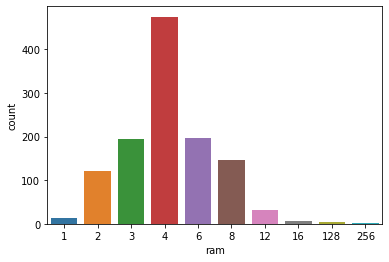

In [7]:
sns.countplot(x="ram", data=df);

In [8]:
df = df.drop(df[df['ram'] > 16].index)

К тому же стоит обратить внимание на то, что у нас процессоры бывают либо 6 ядерные, либо 8 ядерные, дело в том, что у всех смартфонов от Apple стоят 6 ядерные процессоры, а у остальных 8

In [9]:
print('Уникальные ядра: ', list(df['cpu_core'].unique()))
# Проверим, что кол-во смартфонов с 6 ядерными процессорами совпадает с количеством айфонов
print(df[(df['title'] == 'iPhone') | (df['title'] == 'Apple')].shape[0] == \
                                                    df[df['cpu_core'] == 6].shape[0])
    
df.tail(2)

Уникальные ядра:  [8, 6]
True


,title,price,brand_int,screen_size,ram,msc,mp,cpu_int,cpu_ghz,cpu_core
5224,Apple,59980,7,6.10,4,128,12,9,2.65,6
5345,Nokia,13751,11,6.39,4,64,48,3,2.00,8


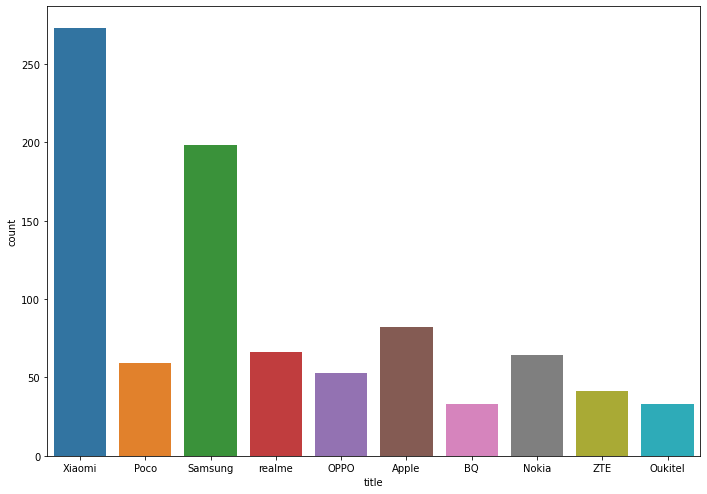

In [10]:
# Посмотрим на количество разной продкуции 10 фирм
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df_brands = df[df['title'].map(lambda x: x in df['title'].value_counts()[:10].index)]
sns.countplot(x="title", ax=ax, data=df_brands);

Подготовим данные для обучения

In [11]:
X = df.drop(['price', 'title'], axis=1) 
y = df['price'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17)

# Lasso

In [14]:
%%time
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(alphas=alphas);
lasso_cv.fit(X_train, y_train);

CPU times: user 277 ms, sys: 20.4 ms, total: 298 ms
Wall time: 241 ms


LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       1.18953407e+01, 1.30490198e+01, 1.43145894e+01, 1.57029012e+01,
       1.72258597e+01, 1.88965234e+01, 2.07292178e+01, 2.27396575e+01,
       2.49450814e+01, 2.73644000e+01, 3.00183581e+01, 3.29297126e+01,
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]))

In [15]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, lasso_cv.predict(X_train)))
print("Mean absolute error (test): %.3f" % mean_absolute_error(y_test, lasso_cv.predict(X_test)))

Mean absolute error (train): 7025.409
Mean absolute error (test): 5915.896


Lasso не лучшим образом справляется с нашей задачей, так как в среднем ошибается на 6000 рублей на тестовых данных, стоит посмотреть в сторону других моделей

# RandomForest

In [18]:
%%time
forest_params = {'max_depth': list(range(6, 14)), 
                 'min_samples_leaf': list(range(1, 4)),
                 'max_features': list(range(6,9)),
                 'n_estimators': [50, 100, 150, 200]}

random_forest = RandomForestRegressor(random_state=17)
forest = GridSearchCV(estimator=random_forest, param_grid=forest_params)
forest.fit(X_train, y_train)

CPU times: user 10min 10s, sys: 6.34 s, total: 10min 16s
Wall time: 10min 42s


GridSearchCV(estimator=RandomForestRegressor(random_state=17),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13],
                         'max_features': [6, 7, 8],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [50, 100, 150, 200]})

In [19]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, forest.predict(X_train)))
print("Mean absolute error (test): %.3f" % mean_absolute_error(y_test, forest.predict(X_test)))

Mean absolute error (train): 1724.936
Mean absolute error (test): 2512.373


С помощью random forest удалость уменьшить нашу ошибку чуть более чем в 2 раза, что уже является довольно неплохим результатом, попробуем ещё XGBoost

# XGBoost

In [22]:
xg_params = {'max_depth': [5, 6, 7],
             'subsample': [1, 2, 3],
             'gamma': [0.4, 0.5, 0.6],
             'reg_alpha': [0.4, 0.5, 0.6],
             'reg_lambda': [0.4, 0.5, 0.6],
             'n_estimators': [100, 300, 500]}


xg = XGBRegressor()
reg = GridSearchCV(xg, xg_params,
                   cv=5, 
                   scoring='neg_mean_absolute_error',
                   verbose=2, refit=True)

In [23]:
%%time
reg.fit(X_train, y_train);

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.4, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.4, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.4, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   2.0s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   2.0s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   2.0s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   2.0s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   2.1s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   2.0s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   2.1s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.4s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   2.1s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   2.1s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.7s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.6s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.9s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.8s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   2.1s
[CV] gamma=0.4, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.3s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.5, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.5, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.1s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.5, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.1s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3 
[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=5, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=5, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=3 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=3 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=6, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=6, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.4s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.5s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.9s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.3s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.3s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.2s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.4s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.3s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=6, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=3 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.5, subsample=3, total=   0.0s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.4s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.3s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.2s
[CV] gamma=0.6, max_depth=7, n_estimators=100, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.1s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.5s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.6s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=300, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.4, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   1.4s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   1.1s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.4, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   1.3s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=1, total=   0.7s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.5, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   1.0s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.8s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1 
[CV]  gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=1, total=   0.9s
[CV] gamma=0.6, max_depth=7, n_estimators=500, reg_alpha=0.6, reg_lambda=0.6, subsample=2 
[CV]  gamma=0.6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 736, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1499, in 

CPU times: user 31min 1s, sys: 2min 34s, total: 33min 35s
Wall time: 14min 15s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [24]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, reg.predict(X_train)))
print("Mean absolute error (test): %.3f" % mean_absolute_error(y_test, reg.predict(X_test)))

Mean absolute error (train): 1130.895
Mean absolute error (test): 2486.994


Как видим, XGBoost совсем незначительно понизил ошибку на тестовых данных, но при этом на обучающей выборе показывает куда меньшую ошибку, чем на тех же данных random forest, вполне вероятно, что он просто больше подвержен переобучению

# Ensemble with RF and XGBoost

С помощью ансамбля из RF и XGBoost можно еще сильнее понизить ошибку нашей модели на тестовых данных, но эти изменения будут незначительными

In [26]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, 
                  ( reg.predict(X_train) + forest.predict(X_train) ) / 2))
print("Mean absolute error (test): %.3f" % mean_absolute_error(y_test, 
                  ( reg.predict(X_test) + forest.predict(X_test) ) / 2))

Mean absolute error (train): 1412.870
Mean absolute error (test): 2422.084
